# Recurrent Neural Networks with Back Propagation through time

---



In [13]:
#You can mount google drive for file data
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## **Installation of necessary libraries**

In [2]:
!pip install numpy nltk csv numpy itertools

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


**Recurrent neural networks:**  A type of neural network architecture well suited for ***processing sequential data*** such as text, audio, time series, and more.

## **Basic Architecture of RNN**

**RNN structure** – A  single computational unit with a self-connected hidden state, through which information cycles across timesteps

**Hidden state output from previous step to present step**  The activations from previous time steps flow as inputs to influence the network’s computations on current data

**Temporal Context and sequence history** Recurrence allows the model prediction to dynamically incorporate temporal context and sequence history, crucial for many seq2seq tasks.



Fig. shows Unfolded architecture view of RNN – LHS shows the feedback of s(t-1) to generate s(t)

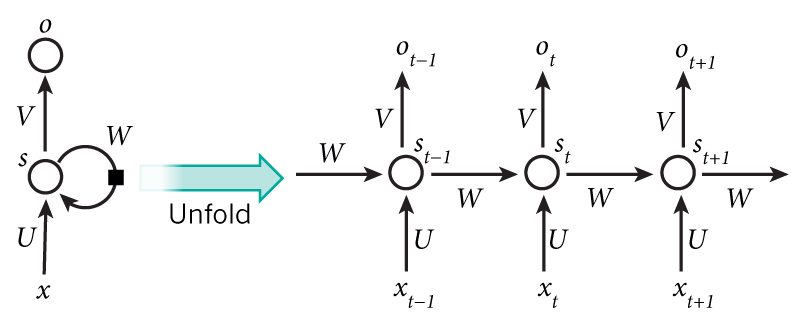

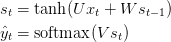

**Recurrent neural networks** A type of neural network architecture well-suited for processing sequential data such as text, audio, time series, and more.

**Key aspect** Recursive computational loops that span adjacent time steps.

**Persistent Internal State** Recurrence enables RNN models to effectively maintain a persistent internal state or ‘memory’ of prior inputs that can inform processing of data points later in the sequence.

**Temporal sharing of Weights** RNN *shares weights across temporally* enables learnt rules in one part of a sequence reapplication on sequence order slight changes.


## **Detailed view of the unfolded network**

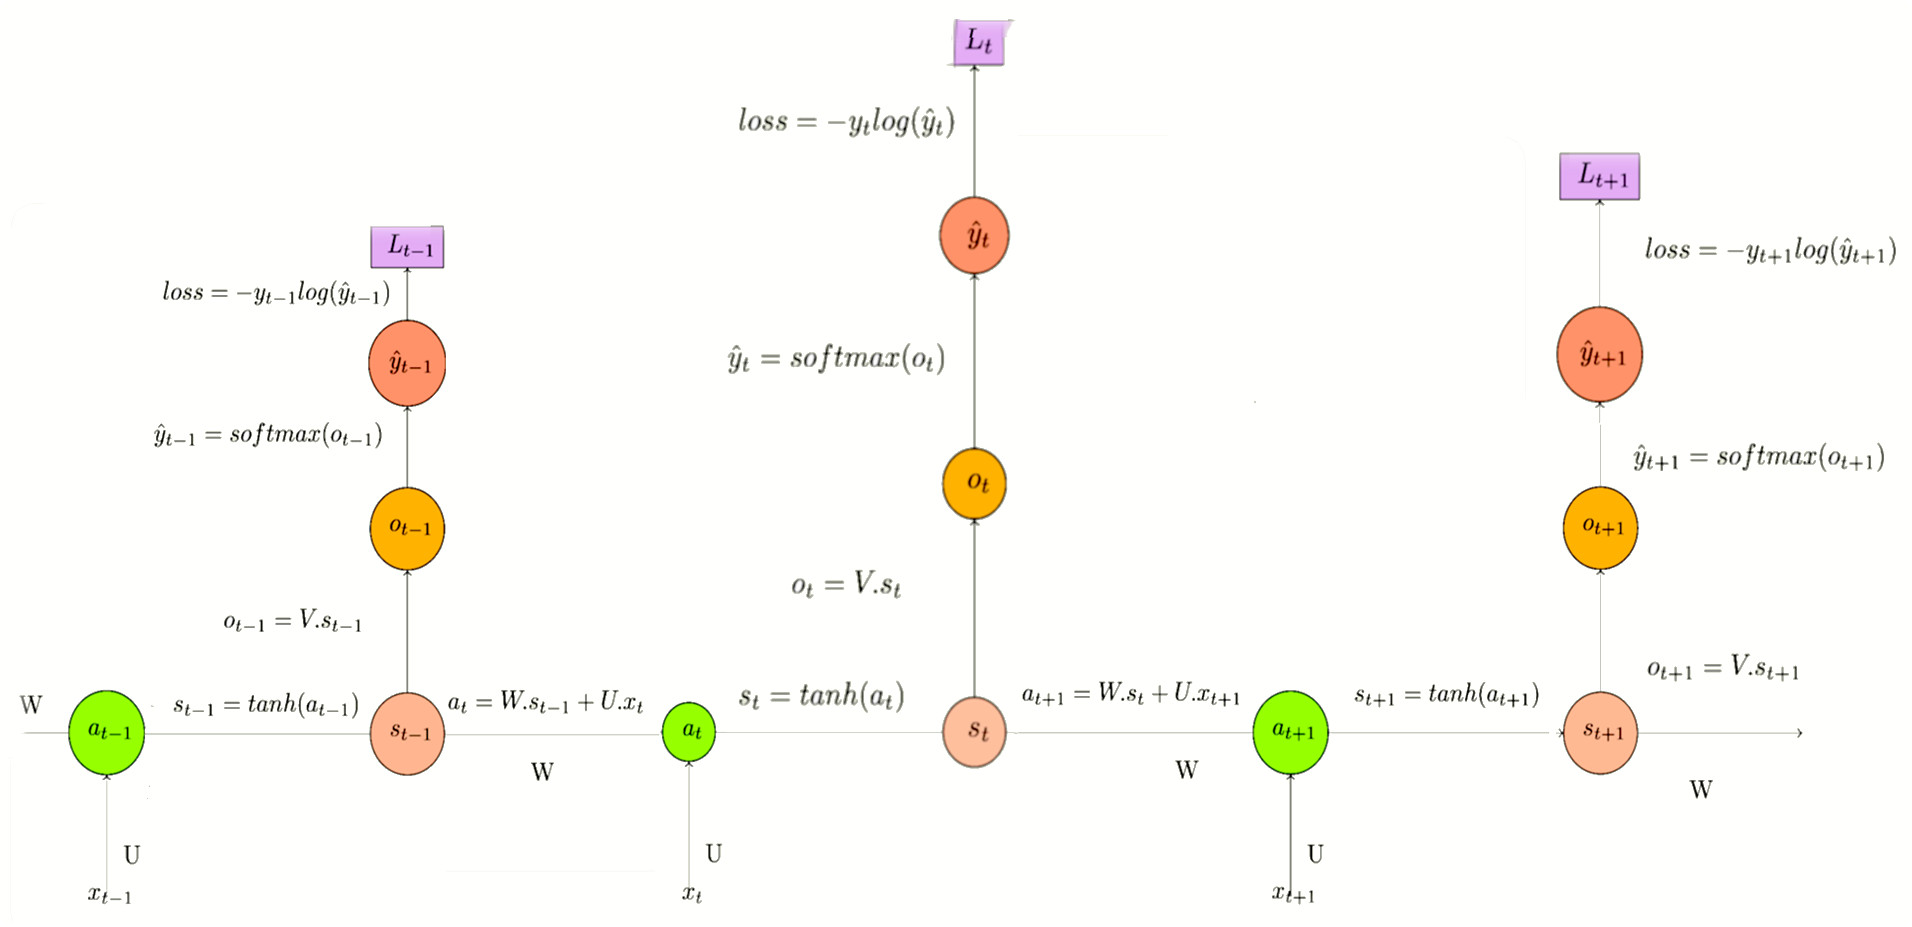

**Loss function and Backward Chaining**

Figures show Unfolded Loss Function relation with activation

 LHS shows the forwarded error in each pass. RHS gives the dependencies of gradients of each pass over its previous output

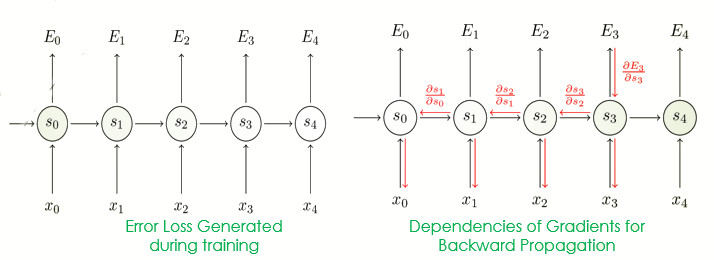

## **Example Computational Graph**

Figure Shows Example computational graph to represent E1 and calculate dE1/dW, dE1/dU

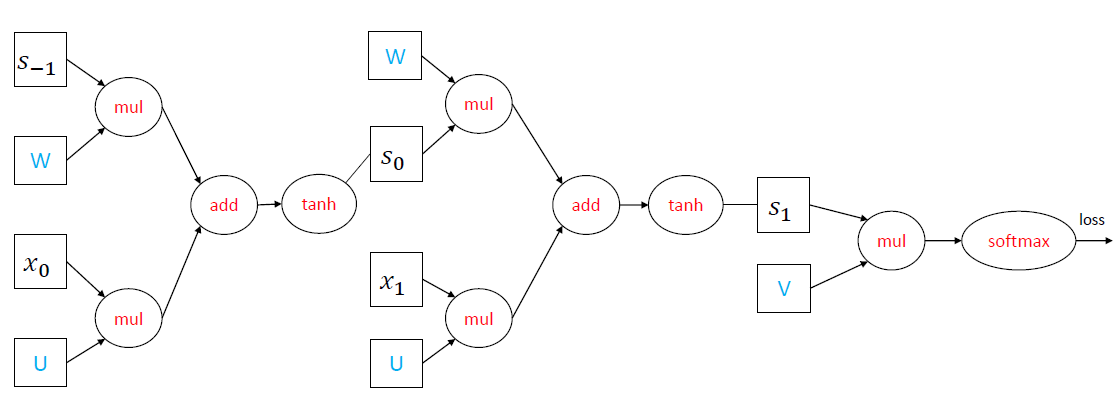

### **Implementation of all operation unit and softmax output**


In [3]:
import numpy as np

class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)

    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2

    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2

In [4]:
import numpy as np

class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff

In [5]:
class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)
        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        probs[y] -= 1.0
        return probs

## **Computational Graph Simplification in Python**
Figure Shows computational graph integrating some small operation units to a big operation unit RNN Layer

RNN Layer implements forward function and backward function


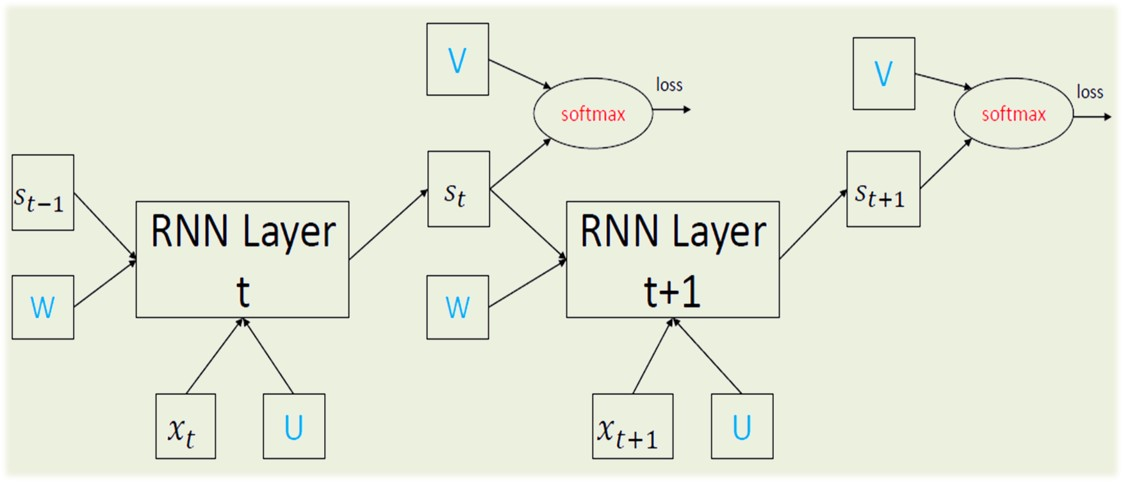

In [6]:
mulGate = MultiplyGate()
addGate = AddGate()
activation = Tanh()

#slide used is available in 'Figure: Backward chaining in bptt' below
class RNNLayer:
    def forward(self, x, prev_s, U, W, V):
        self.mulu = mulGate.forward(U, x)
        self.mulw = mulGate.forward(W, prev_s)
        self.add = addGate.forward(self.mulw, self.mulu) #a(t) = W. s(t-1) + U. x(t)
        self.s = activation.forward(self.add)   # s(t) = tanh(a(t))
        self.mulv = mulGate.forward(V, self.s)  # o(t) = V.s(t) available for Softmax

    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)

        #computing ƏL/ƏV = (y'-y)s(t) where s(t)=tanh(a(t))    i.e. ƏL(t)/ƏV = (y'-y)s(t)     ............3
        #ƏL/Əs(t) = (y'-y)V ....... 5

        dV, dsv = mulGate.backward(V, self.s, dmulv)

        #∂L/∂s(t) = V. ∂L/∂o(t) + ∂L(t+1) / ∂s(t)    .....6 in slide
                            #where ∂L(t+1) is taken from forward pass for this backward step in bptt method

        ds = dsv + diff_s

        #∂L/∂a(t) = (1-tanh(s(t))^2).∂L/∂s(t)   .....7 in slide
        dadd = activation.backward(self.add, ds)

        # useful for array shaping of
        dmulw, dmulu = addGate.backward(self.mulw, self.mulu, dadd)

        # ∂L/∂W = s(t-1) . ∂L/∂a(t) i.e.  ƏL(t)/ƏW = s(t-1) . ƏL(t)/Əa(t) ............8
        # ∂L/∂s(t-1) = W . ∂l/∂a(t) i.e.  ƏL(t)/Əs(t-1) = W. ƏL(t)/Əa(t) ............9 as well as
        #  ƏL(t+1)/Əs(t+1) = W. ƏL(t+1)/Əa(t+1) = ƏL(t+1)/Əs(t)     ............4
        dW, dprev_s = mulGate.backward(W, prev_s, dmulw)

        # ∂L/∂U = x(t) . ∂L/∂a(t) i.e ƏL(t)/ƏU = x(t) . ƏL(t)/Əa(t) ............10

        dU, dx = mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)

## **Definition for Preprocess Input in csv or txt file**
You need to manually import 'data/reddit-comments-2015-08.csv' from the link https://github.com/afzalsd123/HANDS-ON-RNN-LSTM-DAY2/blob/main/reddit-comments-2015-08.csv

**SDG Implementation -Runtime X and Y values traced through spyder IDE**

You can compare how the Y(i) correlates with X(i-1) where i refers to ith word in a sentence

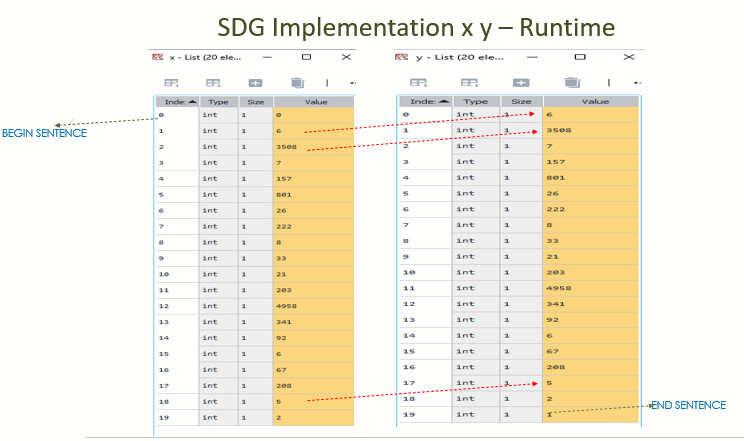

In [15]:
import csv
import numpy as np
import itertools
import nltk
nltk.download('punkt_tab')
#nltk.download('punkt')

global test_vocab
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"
global index_to_word
global word_to_index
def getSentenceData(path, vocabulary_size=8000):
    global test_vocab
    global index_to_word
    global word_to_index
    # Read the data and append SENTENCE_START and SENTENCE_END tokens
    print("Reading CSV file...")
    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, skipinitialspace=True)
        # Split full comments into sentences
        sentences = itertools.chain(*[nltk.sent_tokenize(x[0].lower()) for x in reader])
        '''
        sentences = itertools.chain(*[
             nltk.sent_tokenize(row[0].lower()) for row in reader
              if row and len(row) > 0 and row[0].strip()
             ])
        '''
        # Append SENTENCE_START and SENTENCE_END
        sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
    print("Parsed %d sentences." % (len(sentences)))

    # Tokenize the sentences into words
    tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
    # Filter the sentences having few words (including SENTENCE_START and SENTENCE_END)
    tokenized_sentences = list(filter(lambda x: len(x) > 3, tokenized_sentences))

    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    print("Found %d unique words tokens." % len(word_freq.items()))

    # Get the most common words and build index_to_word and word_to_index vectors
    vocab = word_freq.most_common(vocabulary_size-1)
    index_to_word = [x[0] for x in vocab]
    index_to_word.append(unknown_token)
    word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

    print("Using vocabulary size %d." % vocabulary_size)
    print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

    # Replace all words not in our vocabulary with the unknown token
    for i, sent in enumerate(tokenized_sentences):
        tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

    print("\nExample sentence: '%s'" % sentences[1])
    print("\nExample sentence after Pre-processing: '%s'\n" % tokenized_sentences[0])

    # Create the training data
    X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences],dtype=np.ndarray)
    y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences],dtype=np.ndarray)

    print("X_train shape: " + str(X_train.shape))
    print("y_train shape: " + str(y_train.shape))

    # Print an training data example
    x_example, y_example = X_train[17], y_train[17]
    print("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
    print("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

    test_vocab=vocab
    return X_train, y_train

if __name__ == '__main__':
    X_train, y_train = getSentenceData('data/reddit-comments-2015-08.csv')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Reading CSV file...
Parsed 79185 sentences.
Found 62987 unique words tokens.
Using vocabulary size 8000.
The least frequent word in our vocabulary is 'whitebeard' and appeared 10 times.

Example sentence: 'SENTENCE_START i joined a new league this year and they have different scoring rules than i'm used to. SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'i', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than', 'i', "'m", 'used', 'to', '.', 'SENTENCE_END']'

X_train shape: (78509,)
y_train shape: (78509,)
x:
SENTENCE_START what are n't you understanding about this ? !
[0, 52, 28, 17, 10, 858, 55, 26, 35, 70]

y:
what are n't you understanding about this ? ! SENTENCE_END
[52, 28, 17, 10, 858, 55, 26, 35, 70, 1]


## **Create Model for Recurrent Neural Network and Back Propagation Through Time based Training of RNN**

Following are Backpropagation derivations - partial derivatives of L(t) w.r.t. parameters with backward chaining


**Figure: Backward chaining in bptt**

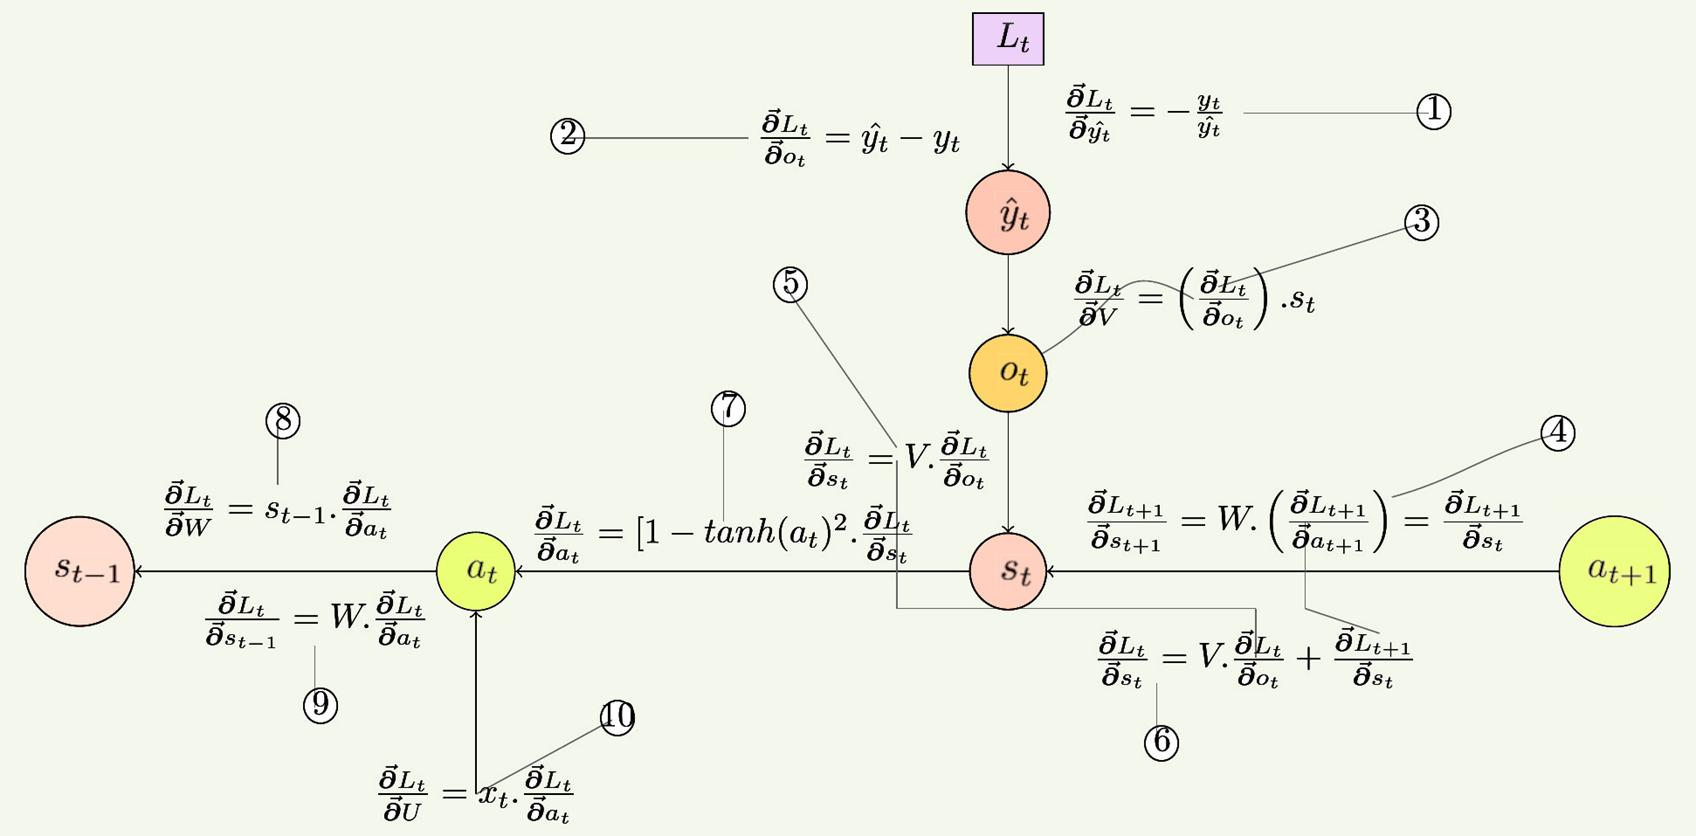

### **Parameter Initializations**

 Weight Parameters U,V and W initialized randomly in the interval
incoming connections from previous layer [-1/√n, 1/√n]
 where n is no. of incoming connections from previous layer.

** U, W, V** are shared in the model across all temporal **RNNLayer**s

 Also defined **bptt** method that takes as input training example (x,y) and return gradients (dL/dU, dL/dW, dL/dV)

In [16]:
from datetime import datetime
import numpy as np
import sys


class Model:
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.U = np.random.uniform(-np.sqrt(1. / word_dim), np.sqrt(1. / word_dim), (hidden_dim, word_dim))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (word_dim, hidden_dim))

    '''
        forward propagation (predicting word probabilities)
        x is one single data, and a batch of data
        for example x = [0, 179, 341, 416], then its y = [179, 341, 416, 1]
    '''

    '''Forward propagation predicting word probabilities'''
    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        layers = []
        prev_s = np.zeros(self.hidden_dim)
        # For each time step...
        for t in range(T):
            layer = RNNLayer()
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            layer.forward(input, prev_s, self.U, self.W, self.V)
            prev_s = layer.s
            layers.append(layer)
        return layers

    '''Predict method to generate result'''
    def predict(self, x):
        output = Softmax()
        layers = self.forward_propagation(x)
        return [np.argmax(output.predict(layer.mulv)) for layer in layers]

    '''Cross-entropy loss and Total Loss'''
    def calculate_loss(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        loss = 0.0
        for i, layer in enumerate(layers):
            loss += output.loss(layer.mulv, y[i])
        return loss / float(len(y))

    def calculate_total_loss(self, X, Y):
        loss = 0.0
        for i in range(len(Y)):
            loss += self.calculate_loss(X[i], Y[i])
        return loss / float(len(Y))

    '''Backpropagation Through Time (BPTT)'''
    '''bptt takes as input training example (x, y) and returns  gradients dLdW, dL/dU and dL/dV'''




    def bptt(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)    #each layer now has the hidden activation s(t) of tanh
        dU = np.zeros(self.U.shape)             #dU,dV and dW are dL/dU,dL/dV,dL/dW respectively
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)

        T = len(layers)
        prev_s_t = np.zeros(self.hidden_dim)
        diff_s = np.zeros(self.hidden_dim)
        for t in range(0, T):
            dmulv = output.diff(layers[t].mulv, y[t])  #take output delta loss
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            #each gradient computed is to be summed up with all layers gradients i.e.
            #- dL/dU(t),dL/dW(t),dL/dV(t) for delta loss (dL) dmulv
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(input, prev_s_t, self.U, self.W, self.V, diff_s, dmulv)
            prev_s_t = layers[t].s
            dmulv = np.zeros(self.word_dim)
            # For each output backward propagate with bptt_truncate steps
            for i in range(t-1, max(-1, t-self.bptt_truncate-1), -1):
                input = np.zeros(self.word_dim)
                input[x[i]] = 1
                prev_s_i = np.zeros(self.hidden_dim) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(input, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
        return (dU, dW, dV)


    def sgd_step(self, x, y, learning_rate):
        dU, dW, dV = self.bptt(x, y)
        self.U -= learning_rate * dU
        self.V -= learning_rate * dV
        self.W -= learning_rate * dW

    def train(self, X, Y, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
        num_examples_seen = 0
        losses = []
        for epoch in range(nepoch):
            if (epoch % evaluate_loss_after == 0):
                loss = self.calculate_total_loss(X, Y)
                losses.append((num_examples_seen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
                # Adjust the learning rate if loss increases
                if len(losses) > 1 and losses[-1][1] > losses[-2][1]:
                    learning_rate = learning_rate * 0.5
                    print("Setting learning rate to %f" % learning_rate)
                sys.stdout.flush()
            # For each training example...
            for i in range(len(Y)):
                self.sgd_step(X[i], Y[i], learning_rate)
                num_examples_seen += 1
        return losses

    def test(self, X):
      num_correct = 0
      for i in range(len(X)):
        predicted_words = self.predict(X[i])
      return predicted_words

**Parameter Initialization - Runtime**

The following images demonstrate the W,U and V matrices after random initializations in _init_ method of **Model** class. Please note the dimensions U(100 x 8000) , V(8000 x 100) and W(100 x 100)
The array objects are variable snapshots from spyder IDE during the project runtime




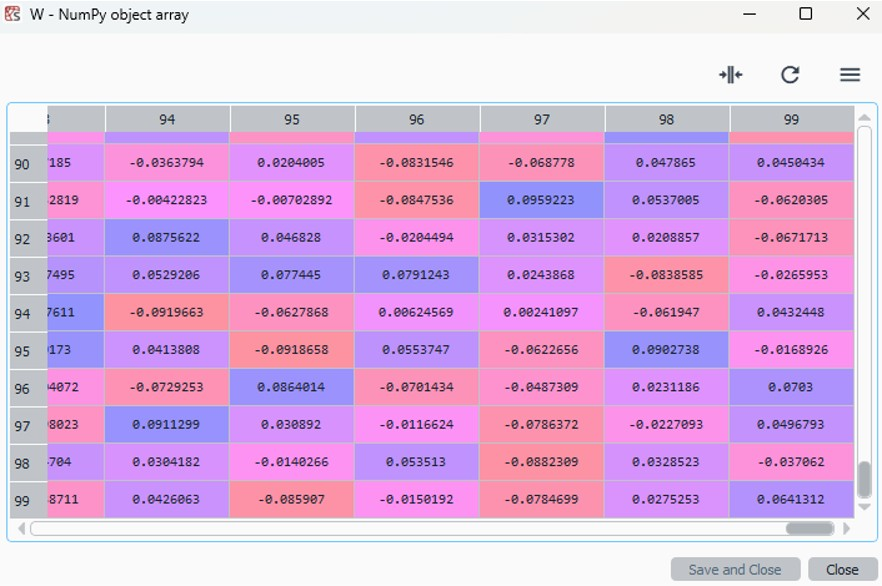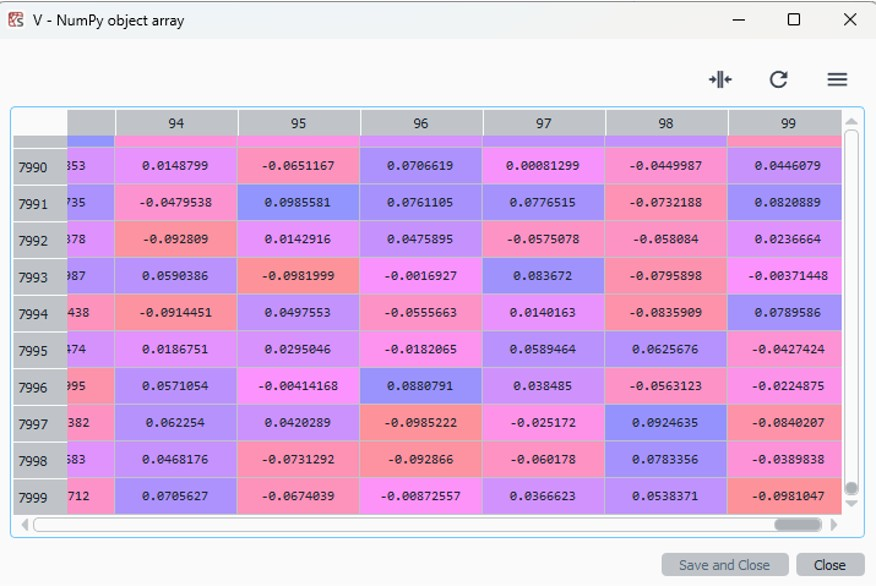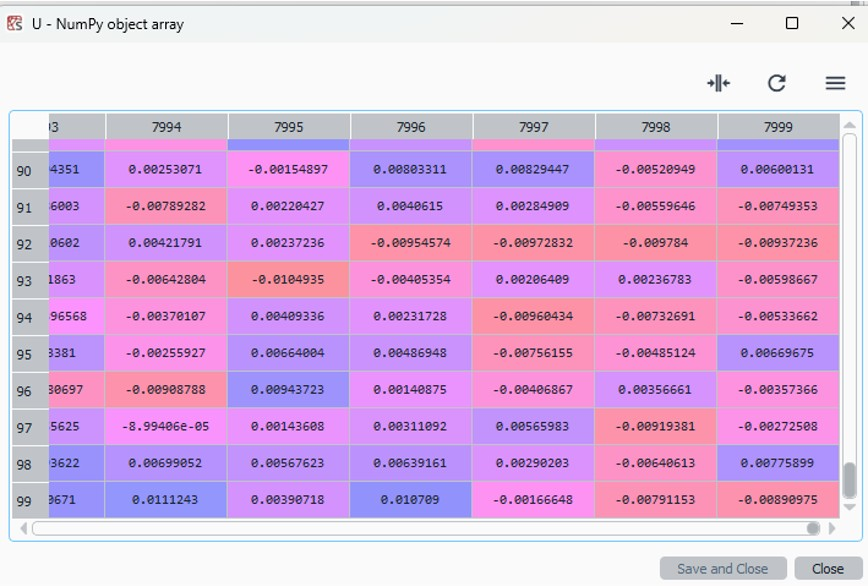

## **Training**


In [17]:
word_dim = 8000
hidden_dim = 100
X_train, y_train = getSentenceData('data/reddit-comments-2015-08.csv', word_dim)

np.random.seed(10)
rnn = Model(word_dim, hidden_dim)

losses = rnn.train(X_train[:100], y_train[:100], learning_rate=0.005, nepoch=10, evaluate_loss_after=1)

Reading CSV file...
Parsed 79185 sentences.
Found 62987 unique words tokens.
Using vocabulary size 8000.
The least frequent word in our vocabulary is 'whitebeard' and appeared 10 times.

Example sentence: 'SENTENCE_START i joined a new league this year and they have different scoring rules than i'm used to. SENTENCE_END'

Example sentence after Pre-processing: '['SENTENCE_START', 'i', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than', 'i', "'m", 'used', 'to', '.', 'SENTENCE_END']'

X_train shape: (78509,)
y_train shape: (78509,)
x:
SENTENCE_START what are n't you understanding about this ? !
[0, 52, 28, 17, 10, 858, 55, 26, 35, 70]

y:
what are n't you understanding about this ? ! SENTENCE_END
[52, 28, 17, 10, 858, 55, 26, 35, 70, 1]
2025-05-07 06:00:00: Loss after num_examples_seen=0 epoch=0: 8.987506
2025-05-07 06:02:25: Loss after num_examples_seen=100 epoch=1: 8.973097
2025-05-07 06:04:46: Loss after num_examples_seen=200

In [23]:
def getTestData(sentence,vocabulary_size):
    sent=nltk.word_tokenize(sentence)
    index_to_word = [x[0] for x in test_vocab]
    index_to_word.append(unknown_token)
    word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])


    # Replace all words not in our vocabulary with the unknown token
    tokenized_sentence = [w if w in word_to_index else unknown_token for w in sent]

    print("\nExample sentence after Pre-processing: '%s'\n" % tokenized_sentence)

    # Create the test data
    print(sent)
    X_train = [[word_to_index[w] for w in tokenized_sentence ]]
    print(X_train)
    x_example = X_train[0]
    print("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
    test_arr=rnn.test(X_train)
    print("x:\n%s" % (" ".join([index_to_word[x] for x in test_arr])))

#you can train for long epochs for fruitful output
getTestData('i joined a new league this year and they have different scoring rules than',8000)



Example sentence after Pre-processing: '['i', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than']'

['i', 'joined', 'a', 'new', 'league', 'this', 'year', 'and', 'they', 'have', 'different', 'scoring', 'rules', 'than']
[[6, 3508, 7, 157, 801, 26, 222, 8, 33, 21, 203, 4958, 341, 92]]
x:
i joined a new league this year and they have different scoring rules than
[6, 3508, 7, 157, 801, 26, 222, 8, 33, 21, 203, 4958, 341, 92]
x:
UNKNOWN_TOKEN the UNKNOWN_TOKEN the the the the the the the the the the the
